In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.preprocessing

from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.tools import optimize_for_inference_lib 

from tensorflow.keras.preprocessing import image as im
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import PIL
from PIL import Image
import glob
import json
import matplotlib.pyplot as plt

In [3]:
dict_string = 'emotion-dictionary.json'
dict_emotion_file = open(dict_string, 'r')
dict_emotion = json.load(dict_emotion_file)
dict_emotion_list = list(dict_emotion)
#retrieve Image and Emotion dictionary

In [4]:
dict_label_emotion = {
    "Happy" : 0, 
    "Not Happy" : 1
}

In [5]:
all_resize_images = glob.glob('data/imgdata-resize/*.jpg')
tt_counter = 0
train_images = []
train_labels = []
test_images = []
test_labels = []
for image_file in all_resize_images:
    if image_file not in dict_emotion_list:
        continue
    else:
        if tt_counter < 9136:
            train_img = Image.open(image_file)
            train_label = dict_emotion[image_file]
            train_images.append(np.asarray(train_img.copy()))
            train_labels.append(dict_label_emotion[train_label])
            train_img.close()
        else:
            test_img = Image.open(image_file)
            test_label = dict_emotion[image_file]
            test_images.append(np.asarray(test_img.copy()))
            test_labels.append(dict_label_emotion[test_label])
            test_img.close()
        tt_counter += 1

In [6]:
#Test code for converting images to arrays
train_images_array = []
test_images_array = []
for image in train_images:
    image_array = im.img_to_array(image)
    
for image in test_images:
    image_array = im.img_to_array(image)

In [7]:
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

In [8]:
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [9]:
dict_image_label = {
    0 : "Happy",
    1 : "Not Happy"
}

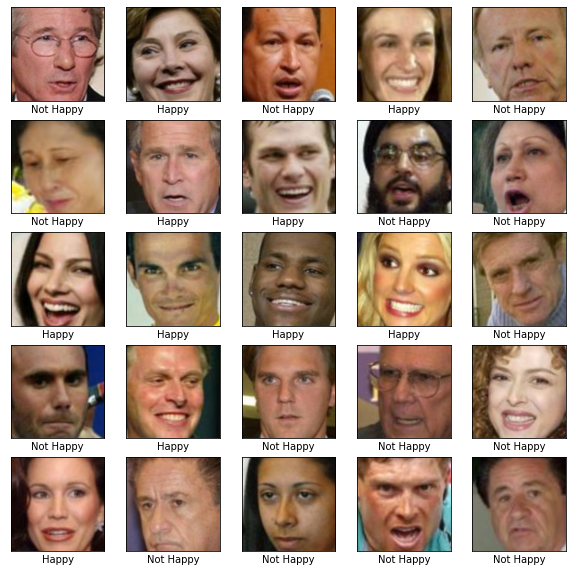

In [10]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, (i % 25) + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap = "gray")
    plt.xlabel(dict_image_label[train_labels[i]])
plt.show()

In [11]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
new_train_images = []
new_train_labels = []
new_test_images = []
new_test_labels = []
happy = 0
not_happy = 0
for i in range(9136):
    if train_labels[i] == 0 and happy < 3000:
        new_train_images.append(train_images[i])
        new_train_labels.append(train_labels[i])
        happy += 1
for i in range(9136):
    if train_labels[i] == 1 and not_happy < 3000:
        new_train_images.append(train_images[i])
        new_train_labels.append(train_labels[i])
        not_happy += 1
happy = 0
not_happy = 0
for i in range(2150):
    if test_labels[i] == 0 and happy < 600:
        new_test_images.append(test_images[i])
        new_test_labels.append(test_labels[i])
        happy += 1
for i in range(2150):
    if test_labels[i] == 1 and not_happy < 600:
        new_test_images.append(test_images[i])
        new_test_labels.append(test_labels[i])
        not_happy += 1

In [ ]:
new_train_images = np.asarray(new_train_images)
new_train_labels = np.asarray(new_train_labels)
new_test_images = np.asarray(new_test_images)
new_test_labels = np.asarray(new_test_labels)
new_train_images = new_train_images / 255.0
new_test_images = new_test_images / 255.0

In [12]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dropout(0.3))
model.add(Dense(400, activation = 'relu'))

model.add(Dropout(0.3))
model.add(Dense(2, activation = 'softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        3

In [14]:
opt = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=10, batch_size=32, 
        validation_data=(test_images, test_labels))

Train on 9136 samples, validate on 2510 samples
Epoch 1/10
9136/9136 [==============================] - 401s 44ms/sample - loss: 0.8678 - acc: 0.5466 - val_loss: 0.6417 - val_acc: 0.6295
Epoch 2/10
9136/9136 [==============================] - 399s 44ms/sample - loss: 0.6366 - acc: 0.6521 - val_loss: 0.5893 - val_acc: 0.7235
Epoch 3/10
9136/9136 [==============================] - 398s 44ms/sample - loss: 0.5919 - acc: 0.6911 - val_loss: 0.6190 - val_acc: 0.6255
Epoch 4/10
9136/9136 [==============================] - 400s 44ms/sample - loss: 0.5491 - acc: 0.7352 - val_loss: 0.5499 - val_acc: 0.7363
Epoch 5/10
9136/9136 [==============================] - 398s 44ms/sample - loss: 0.5287 - acc: 0.7469 - val_loss: 0.5167 - val_acc: 0.7598
Epoch 6/10
9136/9136 [==============================] - 399s 44ms/sample - loss: 0.5289 - acc: 0.7455 - val_loss: 0.5256 - val_acc: 0.7610
Epoch 7/10
9136/9136 [==============================] - 400s 44ms/sample - loss: 0.4800 - acc: 0.7831 - val_loss: 0.52

In [130]:
model_version = '1'
export_dir = 'export/aditya/' + model_version
print('Exporting trained model to', export_dir)
# Build the Protocol Buffer SavedModel at 'export_dir'
my_builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(
    inputs={"inputs": model.input}, outputs={"score": model.output})

Exporting trained model to export/aditya/1
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


In [131]:
import tensorflow.python.keras.backend as K
with K.get_session() as sess:
    my_builder.add_meta_graph_and_variables(
        sess, [tf.saved_model.tag_constants.SERVING],
        signature_def_map={"serving_default": signature},
        main_op=tf.tables_initializer())
my_builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/aditya/1/saved_model.pb


b'export/aditya/1/saved_model.pb'

In [132]:
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)
    
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

In [133]:
model_dir = glob.glob('export/*/*')
model_dir

['export/aditya/1']

In [134]:
import tensorflow as tf
from tensorflow.python.tools import optimize_for_inference_lib
def freeze_graph(model_dir, output_node_names):
    """Extract the sub graph defined by the output nodes and convert 
    all its variables into constant 
    Args:
        model_dir: the root folder containing the checkpoint state file
        output_node_names: a string, containing all the output node's names, 
                            comma separated
    """
    
    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_dir)

        # We use a built-in TF helper to export variables to constants
        input_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

    # We generate the inference graph_def
    output_graph_def = optimize_for_inference_lib.optimize_for_inference(tf.graph_util.remove_training_nodes(input_graph_def),
                                                                         ['conv2d_input'], # an array of the input node(s)
                                                                         output_node_names.split(","), # an array of output nodes
                                                                         tf.float32.as_datatype_enum)
    # Finally we serialize and dump the output graph_def to the filesystem
    with tf.gfile.GFile('frozen_model.pb', "wb") as f:
            f.write(output_graph_def.SerializeToString())
    print("tf magic!")

In [135]:
freeze_graph(model_dir[-1], 'dense_1/Softmax')

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from export/aditya/1/variables/variables
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 20 variables.
INFO:tensorflow:Converted 20 variables to const ops.
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`
tf magic!


In [136]:
import sagemaker

In [137]:
sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='frozen_model.pb', key_prefix='model')